<a href="https://colab.research.google.com/github/tamara-kostova/MSc_Thesis_Neuroimaging/blob/master/04_models_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training and Benchmarking Pipeline

- Benchmark **deep learning architectures** across **4 neuroimaging datasets**
- Implement **transfer learning** with ImageNet pretrained weights
- Apply: early stopping, learning rate scheduling, gradient clipping
- Model comparison

## Imports

In [22]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from pathlib import Path
from datetime import datetime
import pickle

warnings.filterwarnings('ignore')

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model and dataset configuration and hyperparameters

In [24]:
class Config:
    """Global configuration for all models"""

    # Paths
    BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"
    SPLIT_DIR = f"{BASE_DIR}/data/split"
    RESULTS_DIR = f"{BASE_DIR}/results/benchmarks"
    CHECKPOINT_DIR = f"{BASE_DIR}/checkpoints"

    # Training parameters
    BATCH_SIZE = 32
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Random seed
    SEED = 42

    # Datasets to train on
    DATASETS = [
        "MRI_tumor_binary_norm",
        "MRI_tumor_multiclass_norm",
        "MRI_ms_norm",
        "CT_stroke_binary_norm"
    ]

    # Models to benchmark
    MODELS = [
        "resnet50",
        "resnet101",
        "vgg16",
        "densenet121",
        "densenet169",
        "inception_v3",
        "mobilenet_v2",
        "efficientnet_b0",
        "efficientnet_b4",
    ]

    # Early stopping
    PATIENCE = 10
    MIN_DELTA = 1e-3

    def __init__(self):
        os.makedirs(self.RESULTS_DIR, exist_ok=True)
        os.makedirs(self.CHECKPOINT_DIR, exist_ok=True)

## Dataset class

In [25]:
class MedicalImageDataset(Dataset):
    """PyTorch Dataset for medical images with stratified splits"""

    def __init__(self, split_dir, split_type="train", transform=None):
        """
        Args:
            split_dir: path to split directory
            split_type: "train", "val", or "test"
            transform: image transformations
        """
        self.split_dir = split_dir
        self.split_type = split_type
        self.transform = transform

        self.samples = []
        self.class_to_idx = {}
        self._build_samples()

    def _build_samples(self):
        """Build list of (path, label) tuples"""
        split_path = os.path.join(self.split_dir, self.split_type)

        idx = 0
        for class_name in sorted(os.listdir(split_path)):
            class_path = os.path.join(split_path, class_name)

            if not os.path.isdir(class_path):
                continue

            if class_name not in self.class_to_idx:
                self.class_to_idx[class_name] = idx
                idx += 1

            label = self.class_to_idx[class_name]

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        from PIL import Image

        img_path, label = self.samples[idx]

        # Load as grayscale and convert to RGB (3 channels for pretrained models)
        image = Image.open(img_path).convert('L')
        image_rgb = Image.new('RGB', image.size)
        image_rgb.paste(image)

        if self.transform:
            image_rgb = self.transform(image_rgb)

        return image_rgb, label

## Dataset loading
### Input processing

- Load PNG → Convert Grayscale → Pad to RGB (for pretrained models)
- Resize 224×224 (ImageNet standard)
- Normalize (μ=[0.485,0.456,0.406], σ=[0.229,0.224,0.225])

### Augmentation (Training Only)

- Random Horizontal Flip (p=0.5)
- Random Rotation ±10°
- Color Jitter
- Random Affine


In [26]:
def get_data_loaders(split_dir, batch_size=32, num_workers=2):
    """Create train/val/test DataLoaders"""

    # ImageNet normalization
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # Training transforms (with augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=5, scale=(0.9, 1.1)),
        transforms.ToTensor(),
        normalize,
    ])

    # Val/Test transforms (no augmentation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize,
    ])

    # Create datasets
    train_ds = MedicalImageDataset(split_dir, "train", train_transform)
    val_ds = MedicalImageDataset(split_dir, "val", test_transform)
    test_ds = MedicalImageDataset(split_dir, "test", test_transform)

    # Create loaders
    loaders = {
        'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                           num_workers=num_workers, pin_memory=True),
        'val': DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True),
        'test': DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True),
    }

    return loaders, train_ds.class_to_idx

In [27]:
def create_model(model_name, num_classes, pretrained=True):
    """Create model with specified architecture"""

    if model_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "resnet101":
        model = models.resnet101(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "vgg19":
        model = models.vgg19(pretrained=pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "densenet121":
        model = models.densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "densenet169":
        model = models.densenet169(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "inception_v3":
        model = models.inception_v3(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet_b4":
        model = models.efficientnet_b4(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model

In [28]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience=10, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.counter = 0
        self.best_loss = None
        self.best_epoch = None
        self.best_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_state = model.state_dict().copy()
            self.best_epoch = 0
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = model.state_dict().copy()
            self.best_epoch = 0
        else:
            self.counter += 1
            self.best_epoch += 1

        return self.counter >= self.patience

    def restore_best_weights(self, model):
        if self.best_state is not None and self.restore_best:
            model.load_state_dict(self.best_state)

## Training and validation helpers

In [29]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()

    total_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        with torch.no_grad():
            preds = outputs.argmax(dim=1).cpu().numpy()  # [batch_size]
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())  # [batch_size]

        pbar.update(1)

    avg_loss = total_loss / len(loader.dataset)

    all_preds = np.concatenate(all_preds, axis=0)  # [total_samples]
    all_labels = np.concatenate(all_labels, axis=0)  # [total_samples]

    avg_acc = accuracy_score(all_labels, all_preds)

    return avg_loss, avg_acc

In [30]:
def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()

    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1).cpu().numpy()  # [batch_size]
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # [batch_size, num_classes]

            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())  # [batch_size]
            all_probs.append(probs)

            pbar.update(1)

    avg_loss = total_loss / len(loader.dataset)

    all_preds = np.concatenate(all_preds, axis=0)  # [total_samples]
    all_labels = np.concatenate(all_labels, axis=0)  # [total_samples]
    all_probs = np.concatenate(all_probs, axis=0)  # [total_samples, num_classes]

    avg_acc = accuracy_score(all_labels, all_preds)

    # Compute AUC
    try:
        if len(np.unique(all_labels)) == 2:
            # Binary: use positive class probabilities (class 1)
            avg_auc = roc_auc_score(all_labels, all_probs[:, 1])
        else:
            # Multiclass: one-vs-rest
            avg_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except Exception as e:
        print(f"  Warning: Could not compute AUC: {e}")
        avg_auc = 0.0

    return avg_loss, avg_acc, avg_auc

## Main training loop

In [31]:
def train_model(model, loaders, criterion, optimizer, scheduler, device,
                num_epochs, model_name, dataset_name, checkpoint_dir):
    """Train model with early stopping"""

    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_{dataset_name}.pt")

    early_stop = EarlyStopping(patience=Config.PATIENCE, min_delta=Config.MIN_DELTA)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': []
    }

    print(f"\n{'='*70}")
    print(f"Training {model_name} on {dataset_name}")
    print(f"{'='*70}")

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            model, loaders['train'], criterion, optimizer, device
        )

        val_loss, val_acc, val_auc = validate_epoch(
            model, loaders['val'], criterion, device
        )

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"TrLoss: {train_loss:.4f} | TrAcc: {train_acc:.4f} | "
              f"VaLoss: {val_loss:.4f} | VaAcc: {val_acc:.4f} | VaAUC: {val_auc:.4f}")

        if scheduler is not None:
            scheduler.step(val_loss)

        if early_stop(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            early_stop.restore_best_weights(model)
            break

        if epoch % 5 == 0:
            torch.save(model.state_dict(), checkpoint_path)

    return history, checkpoint_path

In [32]:
def evaluate_model(model, loader, device):
    """Full evaluation metrics"""
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            preds = outputs.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(outputs, dim=1).cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs)

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
    }

    # AUC
    try:
        if len(np.unique(all_labels)) == 2:
            metrics['auc'] = roc_auc_score(all_labels, all_probs[:, 1])
        else:
            metrics['auc'] = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except Exception as e:
        print(f"  Warning: Could not compute AUC: {e}")
        metrics['auc'] = 0.0

    return metrics, all_preds, all_labels

In [33]:
def save_results(results, output_path):
    """Save results to JSON"""
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=2, default=str)

In [34]:
config = Config()
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)
all_results = {}

## Training Pipeline

- CrossEntropy Loss
- Adam Optimizer
- Scheduler - adaptive LR reduction
- Gradient clipping
- Early stopping

In [35]:
for dataset_name in config.DATASETS:
        dataset_path = os.path.join(config.SPLIT_DIR, dataset_name)

        if not os.path.exists(dataset_path):
            print(f"Dataset not found: {dataset_path}")
            continue

        print(f"\n\n{'#'*70}")
        print(f"# DATASET: {dataset_name}")
        print(f"{'#'*70}")

        loaders, class_to_idx = get_data_loaders(
            dataset_path,
            batch_size=config.BATCH_SIZE,
            num_workers=2
        )

        num_classes = len(class_to_idx)
        print(f"Number of classes: {num_classes}")
        print(f"Classes: {list(class_to_idx.keys())}")

        dataset_results = {}

        for model_name in config.MODELS:
            try:
                print(f"\n--- Training {model_name} ---")

                model = create_model(model_name, num_classes, pretrained=True)
                model = model.to(config.DEVICE)

                total_params = sum(p.numel() for p in model.parameters())
                trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
                print(f"Parameters: {total_params/1e6:.2f}M (trainable: {trainable_params/1e6:.2f}M)")

                criterion = nn.CrossEntropyLoss()

                optimizer = optim.AdamW(
                    model.parameters(),
                    lr=config.LEARNING_RATE,
                    weight_decay=config.WEIGHT_DECAY
                )

                scheduler = ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.5, patience=5
                )

                history, checkpoint_path = train_model(
                    model, loaders, criterion, optimizer, scheduler, config.DEVICE,
                    config.NUM_EPOCHS, model_name, dataset_name, config.CHECKPOINT_DIR
                )

                model.load_state_dict(torch.load(checkpoint_path, map_location=config.DEVICE))

                test_metrics, _, _ = evaluate_model(model, loaders['test'], config.DEVICE)

                print(f"\nTest Results:")
                for metric, value in test_metrics.items():
                    print(f"  {metric}: {value:.4f}")

                dataset_results[model_name] = {
                    'test_metrics': test_metrics,
                    'history': history,
                    'params': trainable_params,
                }

            except Exception as e:
                print(f"Error training {model_name}: {str(e)}")
                dataset_results[model_name] = {'error': str(e)}

        all_results[dataset_name] = dataset_results



######################################################################
# DATASET: MRI_tumor_binary_norm
######################################################################
Number of classes: 2
Classes: ['normal', 'tumor']

--- Training resnet50 ---
Parameters: 23.51M (trainable: 23.51M)

Training resnet50 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.1662 | TrAcc: 0.9343 | VaLoss: 0.0391 | VaAcc: 0.9867 | VaAUC: 0.9988


Epoch   2/5 | TrLoss: 0.0568 | TrAcc: 0.9829 | VaLoss: 0.0074 | VaAcc: 0.9978 | VaAUC: 1.0000


Epoch   3/5 | TrLoss: 0.0324 | TrAcc: 0.9886 | VaLoss: 0.0083 | VaAcc: 0.9978 | VaAUC: 1.0000


Epoch   4/5 | TrLoss: 0.0073 | TrAcc: 0.9971 | VaLoss: 0.0112 | VaAcc: 0.9978 | VaAUC: 0.9999


Epoch   5/5 | TrLoss: 0.0176 | TrAcc: 0.9952 | VaLoss: 0.0097 | VaAcc: 0.9978 | VaAUC: 1.0000



Test Results:
  accuracy: 0.9822
  precision: 0.9824
  recall: 0.9822
  f1: 0.9822
  auc: 0.9991

--- Training resnet101 ---
Parameters: 42.50M (trainable: 42.50M)

Training resnet101 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.1481 | TrAcc: 0.9390 | VaLoss: 0.0574 | VaAcc: 0.9867 | VaAUC: 0.9963


Epoch   2/5 | TrLoss: 0.0555 | TrAcc: 0.9857 | VaLoss: 0.0809 | VaAcc: 0.9822 | VaAUC: 0.9980


Epoch   3/5 | TrLoss: 0.0465 | TrAcc: 0.9852 | VaLoss: 0.1446 | VaAcc: 0.9844 | VaAUC: 0.9929


Epoch   4/5 | TrLoss: 0.0312 | TrAcc: 0.9919 | VaLoss: 0.0067 | VaAcc: 0.9978 | VaAUC: 1.0000


Epoch   5/5 | TrLoss: 0.0256 | TrAcc: 0.9924 | VaLoss: 0.0136 | VaAcc: 0.9933 | VaAUC: 0.9999



Test Results:
  accuracy: 0.9956
  precision: 0.9956
  recall: 0.9956
  f1: 0.9956
  auc: 0.9993

--- Training vgg16 ---
Parameters: 134.27M (trainable: 134.27M)

Training vgg16 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.3378 | TrAcc: 0.8638 | VaLoss: 0.0917 | VaAcc: 0.9689 | VaAUC: 0.9964


Epoch   2/5 | TrLoss: 0.1178 | TrAcc: 0.9719 | VaLoss: 0.0800 | VaAcc: 0.9822 | VaAUC: 0.9986


Epoch   3/5 | TrLoss: 0.0662 | TrAcc: 0.9838 | VaLoss: 0.1331 | VaAcc: 0.9844 | VaAUC: 0.9972


Epoch   4/5 | TrLoss: 0.0621 | TrAcc: 0.9829 | VaLoss: 0.0318 | VaAcc: 0.9867 | VaAUC: 0.9999


Epoch   5/5 | TrLoss: 0.0440 | TrAcc: 0.9895 | VaLoss: 0.1014 | VaAcc: 0.9844 | VaAUC: 0.9995



Test Results:
  accuracy: 0.9800
  precision: 0.9801
  recall: 0.9800
  f1: 0.9800
  auc: 0.9991

--- Training densenet121 ---
Parameters: 6.96M (trainable: 6.96M)

Training densenet121 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.2146 | TrAcc: 0.9143 | VaLoss: 0.0477 | VaAcc: 0.9867 | VaAUC: 0.9992


Epoch   2/5 | TrLoss: 0.0423 | TrAcc: 0.9876 | VaLoss: 0.0203 | VaAcc: 0.9978 | VaAUC: 0.9996


Epoch   3/5 | TrLoss: 0.0245 | TrAcc: 0.9914 | VaLoss: 0.0143 | VaAcc: 0.9956 | VaAUC: 1.0000


Epoch   4/5 | TrLoss: 0.0173 | TrAcc: 0.9943 | VaLoss: 0.0120 | VaAcc: 0.9978 | VaAUC: 0.9998


Epoch   5/5 | TrLoss: 0.0117 | TrAcc: 0.9971 | VaLoss: 0.0045 | VaAcc: 0.9978 | VaAUC: 1.0000



Test Results:
  accuracy: 0.9778
  precision: 0.9779
  recall: 0.9778
  f1: 0.9778
  auc: 0.9992

--- Training densenet169 ---
Parameters: 12.49M (trainable: 12.49M)

Training densenet169 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.1632 | TrAcc: 0.9414 | VaLoss: 0.0247 | VaAcc: 0.9911 | VaAUC: 0.9998


Epoch   2/5 | TrLoss: 0.0447 | TrAcc: 0.9871 | VaLoss: 0.0191 | VaAcc: 0.9933 | VaAUC: 0.9998


Epoch   3/5 | TrLoss: 0.0118 | TrAcc: 0.9967 | VaLoss: 0.0222 | VaAcc: 0.9911 | VaAUC: 0.9998


Epoch   4/5 | TrLoss: 0.0302 | TrAcc: 0.9910 | VaLoss: 0.0095 | VaAcc: 0.9956 | VaAUC: 1.0000


Epoch   5/5 | TrLoss: 0.0116 | TrAcc: 0.9957 | VaLoss: 0.0232 | VaAcc: 0.9889 | VaAUC: 0.9997



Test Results:
  accuracy: 0.9822
  precision: 0.9823
  recall: 0.9822
  f1: 0.9822
  auc: 0.9972

--- Training inception_v3 ---
Parameters: 24.35M (trainable: 24.35M)

Training inception_v3 on MRI_tumor_binary_norm


Error training inception_v3: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

--- Training mobilenet_v2 ---
Parameters: 2.23M (trainable: 2.23M)

Training mobilenet_v2 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.2277 | TrAcc: 0.9057 | VaLoss: 0.0692 | VaAcc: 0.9800 | VaAUC: 0.9975


Epoch   2/5 | TrLoss: 0.0650 | TrAcc: 0.9800 | VaLoss: 0.0450 | VaAcc: 0.9844 | VaAUC: 0.9990


Epoch   3/5 | TrLoss: 0.0316 | TrAcc: 0.9890 | VaLoss: 0.0513 | VaAcc: 0.9844 | VaAUC: 0.9981


Epoch   4/5 | TrLoss: 0.0285 | TrAcc: 0.9929 | VaLoss: 0.0353 | VaAcc: 0.9889 | VaAUC: 0.9997


Epoch   5/5 | TrLoss: 0.0269 | TrAcc: 0.9933 | VaLoss: 0.0373 | VaAcc: 0.9889 | VaAUC: 0.9995



Test Results:
  accuracy: 0.9867
  precision: 0.9867
  recall: 0.9867
  f1: 0.9867
  auc: 0.9986

--- Training efficientnet_b0 ---
Parameters: 4.01M (trainable: 4.01M)

Training efficientnet_b0 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.3732 | TrAcc: 0.8490 | VaLoss: 0.1145 | VaAcc: 0.9622 | VaAUC: 0.9960


Epoch   2/5 | TrLoss: 0.0911 | TrAcc: 0.9719 | VaLoss: 0.0360 | VaAcc: 0.9822 | VaAUC: 0.9993


Epoch   3/5 | TrLoss: 0.0546 | TrAcc: 0.9805 | VaLoss: 0.0245 | VaAcc: 0.9889 | VaAUC: 0.9996


Epoch   4/5 | TrLoss: 0.0365 | TrAcc: 0.9881 | VaLoss: 0.0253 | VaAcc: 0.9911 | VaAUC: 0.9997


Epoch   5/5 | TrLoss: 0.0218 | TrAcc: 0.9914 | VaLoss: 0.0234 | VaAcc: 0.9889 | VaAUC: 0.9998



Test Results:
  accuracy: 0.9533
  precision: 0.9554
  recall: 0.9533
  f1: 0.9533
  auc: 0.9948

--- Training efficientnet_b4 ---
Parameters: 17.55M (trainable: 17.55M)

Training efficientnet_b4 on MRI_tumor_binary_norm


Epoch   1/5 | TrLoss: 0.6122 | TrAcc: 0.7210 | VaLoss: 0.4930 | VaAcc: 0.8244 | VaAUC: 0.9424


Epoch   2/5 | TrLoss: 0.3227 | TrAcc: 0.8962 | VaLoss: 0.1804 | VaAcc: 0.9311 | VaAUC: 0.9864


Epoch   3/5 | TrLoss: 0.1492 | TrAcc: 0.9486 | VaLoss: 0.0855 | VaAcc: 0.9667 | VaAUC: 0.9970


Epoch   4/5 | TrLoss: 0.0981 | TrAcc: 0.9657 | VaLoss: 0.0576 | VaAcc: 0.9733 | VaAUC: 0.9989


Epoch   5/5 | TrLoss: 0.0853 | TrAcc: 0.9714 | VaLoss: 0.0383 | VaAcc: 0.9867 | VaAUC: 0.9993



Test Results:
  accuracy: 0.8467
  precision: 0.8654
  recall: 0.8467
  f1: 0.8447
  auc: 0.9461


######################################################################
# DATASET: MRI_tumor_multiclass_norm
######################################################################
Number of classes: 12
Classes: ['Carcinoma', 'Germinoma', 'Glioma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Normal', 'Other', 'Papiloma', 'Schwannoma', 'Ttuberculoma']

--- Training resnet50 ---
Parameters: 23.53M (trainable: 23.53M)

Training resnet50 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 0.9112 | TrAcc: 0.7142 | VaLoss: 0.5732 | VaAcc: 0.8208 | VaAUC: 0.9723


Epoch   2/5 | TrLoss: 0.3941 | TrAcc: 0.8740 | VaLoss: 0.3421 | VaAcc: 0.9003 | VaAUC: 0.9907


Epoch   3/5 | TrLoss: 0.2544 | TrAcc: 0.9206 | VaLoss: 0.2107 | VaAcc: 0.9322 | VaAUC: 0.9977


Epoch   4/5 | TrLoss: 0.1769 | TrAcc: 0.9420 | VaLoss: 0.1952 | VaAcc: 0.9456 | VaAUC: 0.9957


Epoch   5/5 | TrLoss: 0.1253 | TrAcc: 0.9582 | VaLoss: 0.2062 | VaAcc: 0.9422 | VaAUC: 0.9979



Test Results:
  accuracy: 0.8145
  precision: 0.8291
  recall: 0.8145
  f1: 0.8059
  auc: 0.9750

--- Training resnet101 ---
Parameters: 42.52M (trainable: 42.52M)

Training resnet101 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 0.9069 | TrAcc: 0.7129 | VaLoss: 0.5701 | VaAcc: 0.8191 | VaAUC: 0.9764


Epoch   2/5 | TrLoss: 0.4049 | TrAcc: 0.8821 | VaLoss: 0.3705 | VaAcc: 0.8777 | VaAUC: 0.9908


Epoch   3/5 | TrLoss: 0.2668 | TrAcc: 0.9177 | VaLoss: 0.3176 | VaAcc: 0.9062 | VaAUC: 0.9894


Epoch   4/5 | TrLoss: 0.2097 | TrAcc: 0.9395 | VaLoss: 0.2277 | VaAcc: 0.9338 | VaAUC: 0.9950


Epoch   5/5 | TrLoss: 0.1595 | TrAcc: 0.9512 | VaLoss: 0.1826 | VaAcc: 0.9422 | VaAUC: 0.9947



Test Results:
  accuracy: 0.8204
  precision: 0.8538
  recall: 0.8204
  f1: 0.8196
  auc: 0.9777

--- Training vgg16 ---
Parameters: 134.31M (trainable: 134.31M)

Training vgg16 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 1.2850 | TrAcc: 0.5805 | VaLoss: 0.7036 | VaAcc: 0.7638 | VaAUC: 0.9625


Epoch   2/5 | TrLoss: 0.6504 | TrAcc: 0.7864 | VaLoss: 0.5478 | VaAcc: 0.8199 | VaAUC: 0.9786


Epoch   3/5 | TrLoss: 0.4390 | TrAcc: 0.8585 | VaLoss: 0.4350 | VaAcc: 0.8735 | VaAUC: 0.9853


Epoch   4/5 | TrLoss: 0.3174 | TrAcc: 0.9008 | VaLoss: 0.3106 | VaAcc: 0.9070 | VaAUC: 0.9894


Epoch   5/5 | TrLoss: 0.2255 | TrAcc: 0.9257 | VaLoss: 0.2507 | VaAcc: 0.9296 | VaAUC: 0.9932



Test Results:
  accuracy: 0.7611
  precision: 0.7376
  recall: 0.7611
  f1: 0.7351
  auc: 0.9640

--- Training densenet121 ---
Parameters: 6.97M (trainable: 6.97M)

Training densenet121 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 1.0019 | TrAcc: 0.7052 | VaLoss: 0.5432 | VaAcc: 0.8333 | VaAUC: 0.9822


Epoch   2/5 | TrLoss: 0.4238 | TrAcc: 0.8733 | VaLoss: 0.3603 | VaAcc: 0.8945 | VaAUC: 0.9892


Epoch   3/5 | TrLoss: 0.2353 | TrAcc: 0.9332 | VaLoss: 0.2194 | VaAcc: 0.9389 | VaAUC: 0.9950


Epoch   4/5 | TrLoss: 0.1583 | TrAcc: 0.9563 | VaLoss: 0.2286 | VaAcc: 0.9296 | VaAUC: 0.9960


Epoch   5/5 | TrLoss: 0.1117 | TrAcc: 0.9705 | VaLoss: 0.1703 | VaAcc: 0.9539 | VaAUC: 0.9946



Test Results:
  accuracy: 0.8530
  precision: 0.8500
  recall: 0.8530
  f1: 0.8331
  auc: 0.9797

--- Training densenet169 ---
Parameters: 12.50M (trainable: 12.50M)

Training densenet169 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 0.9327 | TrAcc: 0.7178 | VaLoss: 0.5316 | VaAcc: 0.8400 | VaAUC: 0.9823


Epoch   2/5 | TrLoss: 0.3651 | TrAcc: 0.8918 | VaLoss: 0.2840 | VaAcc: 0.9070 | VaAUC: 0.9948


Epoch   3/5 | TrLoss: 0.2027 | TrAcc: 0.9419 | VaLoss: 0.1894 | VaAcc: 0.9347 | VaAUC: 0.9980


Epoch   4/5 | TrLoss: 0.1344 | TrAcc: 0.9620 | VaLoss: 0.1478 | VaAcc: 0.9472 | VaAUC: 0.9986


Epoch   5/5 | TrLoss: 0.0945 | TrAcc: 0.9712 | VaLoss: 0.1504 | VaAcc: 0.9447 | VaAUC: 0.9983



Test Results:
  accuracy: 0.8429
  precision: 0.8501
  recall: 0.8429
  f1: 0.8334
  auc: 0.9840

--- Training inception_v3 ---
Parameters: 24.38M (trainable: 24.38M)

Training inception_v3 on MRI_tumor_multiclass_norm


Error training inception_v3: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

--- Training mobilenet_v2 ---
Parameters: 2.24M (trainable: 2.24M)

Training mobilenet_v2 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 1.1079 | TrAcc: 0.6494 | VaLoss: 0.6555 | VaAcc: 0.7956 | VaAUC: 0.9654


Epoch   2/5 | TrLoss: 0.5253 | TrAcc: 0.8414 | VaLoss: 0.4037 | VaAcc: 0.8752 | VaAUC: 0.9850


Epoch   3/5 | TrLoss: 0.3393 | TrAcc: 0.8947 | VaLoss: 0.2756 | VaAcc: 0.9171 | VaAUC: 0.9924


Epoch   4/5 | TrLoss: 0.2206 | TrAcc: 0.9343 | VaLoss: 0.2358 | VaAcc: 0.9322 | VaAUC: 0.9958


Epoch   5/5 | TrLoss: 0.1516 | TrAcc: 0.9539 | VaLoss: 0.1826 | VaAcc: 0.9389 | VaAUC: 0.9927



Test Results:
  accuracy: 0.7845
  precision: 0.7960
  recall: 0.7845
  f1: 0.7689
  auc: 0.9669

--- Training efficientnet_b0 ---
Parameters: 4.02M (trainable: 4.02M)

Training efficientnet_b0 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 1.4029 | TrAcc: 0.5792 | VaLoss: 0.8394 | VaAcc: 0.7496 | VaAUC: 0.9405


Epoch   2/5 | TrLoss: 0.7058 | TrAcc: 0.7822 | VaLoss: 0.4899 | VaAcc: 0.8534 | VaAUC: 0.9795


Epoch   3/5 | TrLoss: 0.4569 | TrAcc: 0.8573 | VaLoss: 0.3872 | VaAcc: 0.8735 | VaAUC: 0.9882


Epoch   4/5 | TrLoss: 0.3407 | TrAcc: 0.8976 | VaLoss: 0.2539 | VaAcc: 0.9271 | VaAUC: 0.9949


Epoch   5/5 | TrLoss: 0.2435 | TrAcc: 0.9255 | VaLoss: 0.1806 | VaAcc: 0.9430 | VaAUC: 0.9967



Test Results:
  accuracy: 0.7360
  precision: 0.7331
  recall: 0.7360
  f1: 0.7069
  auc: 0.9439

--- Training efficientnet_b4 ---
Parameters: 17.57M (trainable: 17.57M)

Training efficientnet_b4 on MRI_tumor_multiclass_norm


Epoch   1/5 | TrLoss: 1.8963 | TrAcc: 0.3515 | VaLoss: 1.5353 | VaAcc: 0.5059 | VaAUC: 0.8282


Epoch   2/5 | TrLoss: 1.3159 | TrAcc: 0.5808 | VaLoss: 1.0508 | VaAcc: 0.6742 | VaAUC: 0.9236


Epoch   3/5 | TrLoss: 0.9541 | TrAcc: 0.7001 | VaLoss: 0.7466 | VaAcc: 0.7906 | VaAUC: 0.9564


Epoch   4/5 | TrLoss: 0.7265 | TrAcc: 0.7729 | VaLoss: 0.5772 | VaAcc: 0.8266 | VaAUC: 0.9730


Epoch   5/5 | TrLoss: 0.5682 | TrAcc: 0.8306 | VaLoss: 0.4693 | VaAcc: 0.8534 | VaAUC: 0.9830



Test Results:
  accuracy: 0.5171
  precision: 0.5176
  recall: 0.5171
  f1: 0.4545
  auc: 0.8306


######################################################################
# DATASET: MRI_ms_norm
######################################################################
Number of classes: 2
Classes: ['Control', 'MS']

--- Training resnet50 ---
Parameters: 23.51M (trainable: 23.51M)

Training resnet50 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.5922 | TrAcc: 0.6587 | VaLoss: 0.5470 | VaAcc: 0.6741 | VaAUC: 0.6898


Epoch   2/5 | TrLoss: 0.5451 | TrAcc: 0.6525 | VaLoss: 0.4990 | VaAcc: 0.6365 | VaAUC: 0.7189


Epoch   3/5 | TrLoss: 0.5071 | TrAcc: 0.6803 | VaLoss: 0.4955 | VaAcc: 0.6587 | VaAUC: 0.7295


Epoch   4/5 | TrLoss: 0.5073 | TrAcc: 0.6796 | VaLoss: 0.4789 | VaAcc: 0.6741 | VaAUC: 0.7601


Epoch   5/5 | TrLoss: 0.5047 | TrAcc: 0.6789 | VaLoss: 0.5376 | VaAcc: 0.6809 | VaAUC: 0.7205



Test Results:
  accuracy: 0.6758
  precision: 0.6112
  recall: 0.6758
  f1: 0.5840
  auc: 0.6897

--- Training resnet101 ---
Parameters: 42.50M (trainable: 42.50M)

Training resnet101 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.5892 | TrAcc: 0.6628 | VaLoss: 0.5316 | VaAcc: 0.6604 | VaAUC: 0.6967


Epoch   2/5 | TrLoss: 0.5480 | TrAcc: 0.6598 | VaLoss: 0.4949 | VaAcc: 0.6894 | VaAUC: 0.7520


Epoch   3/5 | TrLoss: 0.5246 | TrAcc: 0.6609 | VaLoss: 0.4843 | VaAcc: 0.6792 | VaAUC: 0.7403


Epoch   4/5 | TrLoss: 0.5127 | TrAcc: 0.6657 | VaLoss: 0.4874 | VaAcc: 0.6519 | VaAUC: 0.7193


Epoch   5/5 | TrLoss: 0.5170 | TrAcc: 0.6737 | VaLoss: 0.4863 | VaAcc: 0.6792 | VaAUC: 0.7273



Test Results:
  accuracy: 0.6536
  precision: 0.5913
  recall: 0.6536
  f1: 0.5952
  auc: 0.6285

--- Training vgg16 ---
Parameters: 134.27M (trainable: 134.27M)

Training vgg16 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.6282 | TrAcc: 0.6719 | VaLoss: 0.6327 | VaAcc: 0.6809 | VaAUC: 0.6755


Epoch   2/5 | TrLoss: 0.5778 | TrAcc: 0.6778 | VaLoss: 0.6568 | VaAcc: 0.6809 | VaAUC: 0.7146


Epoch   3/5 | TrLoss: 0.5709 | TrAcc: 0.6759 | VaLoss: 0.5866 | VaAcc: 0.6536 | VaAUC: 0.7110


Epoch   4/5 | TrLoss: 0.5558 | TrAcc: 0.6730 | VaLoss: 0.4950 | VaAcc: 0.6911 | VaAUC: 0.7523


Epoch   5/5 | TrLoss: 0.5129 | TrAcc: 0.6668 | VaLoss: 0.4860 | VaAcc: 0.6553 | VaAUC: 0.7382



Test Results:
  accuracy: 0.6809
  precision: 0.4636
  recall: 0.6809
  f1: 0.5516
  auc: 0.6968

--- Training densenet121 ---
Parameters: 6.96M (trainable: 6.96M)

Training densenet121 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.5962 | TrAcc: 0.6532 | VaLoss: 0.5927 | VaAcc: 0.6826 | VaAUC: 0.6784


Epoch   2/5 | TrLoss: 0.5582 | TrAcc: 0.6507 | VaLoss: 0.5439 | VaAcc: 0.6689 | VaAUC: 0.6911


Epoch   3/5 | TrLoss: 0.5464 | TrAcc: 0.6653 | VaLoss: 0.5325 | VaAcc: 0.6365 | VaAUC: 0.6957


Epoch   4/5 | TrLoss: 0.5250 | TrAcc: 0.6690 | VaLoss: 0.5115 | VaAcc: 0.6024 | VaAUC: 0.6707


Epoch   5/5 | TrLoss: 0.4987 | TrAcc: 0.6895 | VaLoss: 0.5006 | VaAcc: 0.6297 | VaAUC: 0.7040



Test Results:
  accuracy: 0.6792
  precision: 0.5700
  recall: 0.6792
  f1: 0.5539
  auc: 0.6948

--- Training densenet169 ---
Parameters: 12.49M (trainable: 12.49M)

Training densenet169 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.5853 | TrAcc: 0.6606 | VaLoss: 0.5574 | VaAcc: 0.6706 | VaAUC: 0.6725


Epoch   2/5 | TrLoss: 0.5392 | TrAcc: 0.6705 | VaLoss: 0.5398 | VaAcc: 0.6706 | VaAUC: 0.7274


Epoch   3/5 | TrLoss: 0.5126 | TrAcc: 0.6734 | VaLoss: 0.5133 | VaAcc: 0.6519 | VaAUC: 0.7189


Epoch   4/5 | TrLoss: 0.5162 | TrAcc: 0.6789 | VaLoss: 0.4827 | VaAcc: 0.6672 | VaAUC: 0.7363


Epoch   5/5 | TrLoss: 0.4918 | TrAcc: 0.6708 | VaLoss: 0.4916 | VaAcc: 0.6177 | VaAUC: 0.7053



Test Results:
  accuracy: 0.6502
  precision: 0.5835
  recall: 0.6502
  f1: 0.5895
  auc: 0.6451

--- Training inception_v3 ---
Parameters: 24.35M (trainable: 24.35M)

Training inception_v3 on MRI_ms_norm


Error training inception_v3: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

--- Training mobilenet_v2 ---
Parameters: 2.23M (trainable: 2.23M)

Training mobilenet_v2 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.5955 | TrAcc: 0.6466 | VaLoss: 0.5584 | VaAcc: 0.6860 | VaAUC: 0.7052


Epoch   2/5 | TrLoss: 0.5625 | TrAcc: 0.6657 | VaLoss: 0.5395 | VaAcc: 0.6536 | VaAUC: 0.6987


Epoch   3/5 | TrLoss: 0.5439 | TrAcc: 0.6672 | VaLoss: 0.5488 | VaAcc: 0.6638 | VaAUC: 0.6866


Epoch   4/5 | TrLoss: 0.5188 | TrAcc: 0.6686 | VaLoss: 0.5099 | VaAcc: 0.6587 | VaAUC: 0.7083


Epoch   5/5 | TrLoss: 0.5058 | TrAcc: 0.6822 | VaLoss: 0.5315 | VaAcc: 0.6519 | VaAUC: 0.6915



Test Results:
  accuracy: 0.6809
  precision: 0.6337
  recall: 0.6809
  f1: 0.6083
  auc: 0.6584

--- Training efficientnet_b0 ---
Parameters: 4.01M (trainable: 4.01M)

Training efficientnet_b0 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.6050 | TrAcc: 0.6346 | VaLoss: 0.5660 | VaAcc: 0.6775 | VaAUC: 0.6856


Epoch   2/5 | TrLoss: 0.5525 | TrAcc: 0.6661 | VaLoss: 0.5446 | VaAcc: 0.6485 | VaAUC: 0.6964


Epoch   3/5 | TrLoss: 0.5307 | TrAcc: 0.6664 | VaLoss: 0.5366 | VaAcc: 0.6399 | VaAUC: 0.6904


Epoch   4/5 | TrLoss: 0.5194 | TrAcc: 0.6814 | VaLoss: 0.5368 | VaAcc: 0.6280 | VaAUC: 0.7068


Epoch   5/5 | TrLoss: 0.5087 | TrAcc: 0.6719 | VaLoss: 0.5242 | VaAcc: 0.6519 | VaAUC: 0.7002



Test Results:
  accuracy: 0.6638
  precision: 0.6219
  recall: 0.6638
  f1: 0.6245
  auc: 0.6758

--- Training efficientnet_b4 ---
Parameters: 17.55M (trainable: 17.55M)

Training efficientnet_b4 on MRI_ms_norm


Epoch   1/5 | TrLoss: 0.6296 | TrAcc: 0.6569 | VaLoss: 0.5967 | VaAcc: 0.6894 | VaAUC: 0.6607


Epoch   2/5 | TrLoss: 0.5883 | TrAcc: 0.6803 | VaLoss: 0.5805 | VaAcc: 0.6792 | VaAUC: 0.6739


Epoch   3/5 | TrLoss: 0.5737 | TrAcc: 0.6829 | VaLoss: 0.5676 | VaAcc: 0.6706 | VaAUC: 0.6870


Epoch   4/5 | TrLoss: 0.5575 | TrAcc: 0.6785 | VaLoss: 0.5507 | VaAcc: 0.6724 | VaAUC: 0.6981


Epoch   5/5 | TrLoss: 0.5475 | TrAcc: 0.6800 | VaLoss: 0.5456 | VaAcc: 0.6553 | VaAUC: 0.6998



Test Results:
  accuracy: 0.6860
  precision: 0.6646
  recall: 0.6860
  f1: 0.5775
  auc: 0.6439


######################################################################
# DATASET: CT_stroke_binary_norm
######################################################################
Number of classes: 2
Classes: ['normal', 'stroke']

--- Training resnet50 ---
Parameters: 23.51M (trainable: 23.51M)

Training resnet50 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.3366 | TrAcc: 0.8565 | VaLoss: 0.2723 | VaAcc: 0.8957 | VaAUC: 0.9495


Epoch   2/5 | TrLoss: 0.2196 | TrAcc: 0.9173 | VaLoss: 0.2486 | VaAcc: 0.9067 | VaAUC: 0.9576


Epoch   3/5 | TrLoss: 0.1893 | TrAcc: 0.9293 | VaLoss: 0.1538 | VaAcc: 0.9378 | VaAUC: 0.9848


Epoch   4/5 | TrLoss: 0.1553 | TrAcc: 0.9426 | VaLoss: 0.2049 | VaAcc: 0.9178 | VaAUC: 0.9768


Epoch   5/5 | TrLoss: 0.1363 | TrAcc: 0.9523 | VaLoss: 0.2122 | VaAcc: 0.9198 | VaAUC: 0.9798



Test Results:
  accuracy: 0.9099
  precision: 0.9154
  recall: 0.9099
  f1: 0.9068
  auc: 0.9587

--- Training resnet101 ---
Parameters: 42.50M (trainable: 42.50M)

Training resnet101 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.3374 | TrAcc: 0.8608 | VaLoss: 0.2914 | VaAcc: 0.8907 | VaAUC: 0.9603


Epoch   2/5 | TrLoss: 0.2279 | TrAcc: 0.9104 | VaLoss: 0.2111 | VaAcc: 0.9208 | VaAUC: 0.9649


Epoch   3/5 | TrLoss: 0.1914 | TrAcc: 0.9237 | VaLoss: 0.2078 | VaAcc: 0.9278 | VaAUC: 0.9713


Epoch   4/5 | TrLoss: 0.1545 | TrAcc: 0.9456 | VaLoss: 0.1993 | VaAcc: 0.9388 | VaAUC: 0.9729


Epoch   5/5 | TrLoss: 0.1371 | TrAcc: 0.9551 | VaLoss: 0.2266 | VaAcc: 0.9258 | VaAUC: 0.9785



Test Results:
  accuracy: 0.9119
  precision: 0.9171
  recall: 0.9119
  f1: 0.9090
  auc: 0.9674

--- Training vgg16 ---
Parameters: 134.27M (trainable: 134.27M)

Training vgg16 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.4553 | TrAcc: 0.8092 | VaLoss: 0.4539 | VaAcc: 0.8074 | VaAUC: 0.9203


Epoch   2/5 | TrLoss: 0.3317 | TrAcc: 0.8754 | VaLoss: 0.3137 | VaAcc: 0.8816 | VaAUC: 0.9352


Epoch   3/5 | TrLoss: 0.2548 | TrAcc: 0.9089 | VaLoss: 0.3142 | VaAcc: 0.8696 | VaAUC: 0.9614


Epoch   4/5 | TrLoss: 0.2156 | TrAcc: 0.9194 | VaLoss: 0.2016 | VaAcc: 0.9268 | VaAUC: 0.9731


Epoch   5/5 | TrLoss: 0.1880 | TrAcc: 0.9327 | VaLoss: 0.1692 | VaAcc: 0.9398 | VaAUC: 0.9767



Test Results:
  accuracy: 0.8338
  precision: 0.8641
  recall: 0.8338
  f1: 0.8163
  auc: 0.9346

--- Training densenet121 ---
Parameters: 6.96M (trainable: 6.96M)

Training densenet121 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.3377 | TrAcc: 0.8492 | VaLoss: 0.2260 | VaAcc: 0.9147 | VaAUC: 0.9670


Epoch   2/5 | TrLoss: 0.2122 | TrAcc: 0.9203 | VaLoss: 0.2002 | VaAcc: 0.9228 | VaAUC: 0.9675


Epoch   3/5 | TrLoss: 0.1668 | TrAcc: 0.9368 | VaLoss: 0.2311 | VaAcc: 0.9338 | VaAUC: 0.9722


Epoch   4/5 | TrLoss: 0.1333 | TrAcc: 0.9495 | VaLoss: 0.1976 | VaAcc: 0.9438 | VaAUC: 0.9723


Epoch   5/5 | TrLoss: 0.1103 | TrAcc: 0.9600 | VaLoss: 0.1698 | VaAcc: 0.9388 | VaAUC: 0.9776



Test Results:
  accuracy: 0.9199
  precision: 0.9233
  recall: 0.9199
  f1: 0.9207
  auc: 0.9754

--- Training densenet169 ---
Parameters: 12.49M (trainable: 12.49M)

Training densenet169 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.3167 | TrAcc: 0.8621 | VaLoss: 0.3349 | VaAcc: 0.8536 | VaAUC: 0.9415


Epoch   2/5 | TrLoss: 0.2087 | TrAcc: 0.9188 | VaLoss: 0.2852 | VaAcc: 0.8877 | VaAUC: 0.9647


Epoch   3/5 | TrLoss: 0.1658 | TrAcc: 0.9366 | VaLoss: 0.2143 | VaAcc: 0.9157 | VaAUC: 0.9749


Epoch   4/5 | TrLoss: 0.1235 | TrAcc: 0.9542 | VaLoss: 0.1405 | VaAcc: 0.9519 | VaAUC: 0.9860


Epoch   5/5 | TrLoss: 0.1067 | TrAcc: 0.9581 | VaLoss: 0.1410 | VaAcc: 0.9519 | VaAUC: 0.9854



Test Results:
  accuracy: 0.8549
  precision: 0.8745
  recall: 0.8549
  f1: 0.8581
  auc: 0.9495

--- Training inception_v3 ---
Parameters: 24.35M (trainable: 24.35M)

Training inception_v3 on CT_stroke_binary_norm


Error training inception_v3: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

--- Training mobilenet_v2 ---
Parameters: 2.23M (trainable: 2.23M)

Training mobilenet_v2 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.3416 | TrAcc: 0.8485 | VaLoss: 0.2698 | VaAcc: 0.8897 | VaAUC: 0.9485


Epoch   2/5 | TrLoss: 0.2351 | TrAcc: 0.9095 | VaLoss: 0.2480 | VaAcc: 0.9127 | VaAUC: 0.9517


Epoch   3/5 | TrLoss: 0.1901 | TrAcc: 0.9284 | VaLoss: 0.2298 | VaAcc: 0.9137 | VaAUC: 0.9755


Epoch   4/5 | TrLoss: 0.1603 | TrAcc: 0.9420 | VaLoss: 0.1848 | VaAcc: 0.9298 | VaAUC: 0.9784


Epoch   5/5 | TrLoss: 0.1392 | TrAcc: 0.9471 | VaLoss: 0.2501 | VaAcc: 0.9087 | VaAUC: 0.9760



Test Results:
  accuracy: 0.9039
  precision: 0.9052
  recall: 0.9039
  f1: 0.9017
  auc: 0.9601

--- Training efficientnet_b0 ---
Parameters: 4.01M (trainable: 4.01M)

Training efficientnet_b0 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.4081 | TrAcc: 0.8217 | VaLoss: 0.3060 | VaAcc: 0.8746 | VaAUC: 0.9315


Epoch   2/5 | TrLoss: 0.2592 | TrAcc: 0.8962 | VaLoss: 0.2328 | VaAcc: 0.9147 | VaAUC: 0.9592


Epoch   3/5 | TrLoss: 0.2062 | TrAcc: 0.9199 | VaLoss: 0.2164 | VaAcc: 0.9147 | VaAUC: 0.9636


Epoch   4/5 | TrLoss: 0.1663 | TrAcc: 0.9317 | VaLoss: 0.2103 | VaAcc: 0.9268 | VaAUC: 0.9735


Epoch   5/5 | TrLoss: 0.1361 | TrAcc: 0.9493 | VaLoss: 0.2090 | VaAcc: 0.9178 | VaAUC: 0.9734



Test Results:
  accuracy: 0.8919
  precision: 0.8913
  recall: 0.8919
  f1: 0.8915
  auc: 0.9375

--- Training efficientnet_b4 ---
Parameters: 17.55M (trainable: 17.55M)

Training efficientnet_b4 on CT_stroke_binary_norm


Epoch   1/5 | TrLoss: 0.5704 | TrAcc: 0.7007 | VaLoss: 0.4660 | VaAcc: 0.7994 | VaAUC: 0.8483


Epoch   2/5 | TrLoss: 0.4145 | TrAcc: 0.8171 | VaLoss: 0.3466 | VaAcc: 0.8445 | VaAUC: 0.9147


Epoch   3/5 | TrLoss: 0.3240 | TrAcc: 0.8621 | VaLoss: 0.3208 | VaAcc: 0.8596 | VaAUC: 0.9364


Epoch   4/5 | TrLoss: 0.2803 | TrAcc: 0.8896 | VaLoss: 0.2500 | VaAcc: 0.8997 | VaAUC: 0.9555


Epoch   5/5 | TrLoss: 0.2400 | TrAcc: 0.9050 | VaLoss: 0.2312 | VaAcc: 0.9137 | VaAUC: 0.9609



Test Results:
  accuracy: 0.8248
  precision: 0.8230
  recall: 0.8248
  f1: 0.8184
  auc: 0.8848


## Results and summary

In [36]:
results_path = os.path.join(config.RESULTS_DIR, f"benchmark_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
save_results(all_results, results_path)

print(f"\n\n{'#'*70}")
print(f"# SUMMARY")
print(f"{'#'*70}")

summary_df = []
for dataset_name, models in all_results.items():
    for model_name, results in models.items():
        if 'test_metrics' in results:
            row = {
                'dataset': dataset_name,
                'model': model_name,
                'accuracy': results['test_metrics']['accuracy'],
                'f1': results['test_metrics']['f1'],
                'auc': results['test_metrics']['auc'],
            }
            summary_df.append(row)

summary_df = pd.DataFrame(summary_df)
summary_df = summary_df.sort_values('accuracy', ascending=False)

print("\nTop Results (by Accuracy):")
print(summary_df.head(10).to_string(index=False))

summary_path = os.path.join(config.RESULTS_DIR, f"summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
summary_df.to_csv(summary_path, index=False)

print(f"\nResults saved to: {results_path}")
print(f"Summary saved to: {summary_path}")



######################################################################
# SUMMARY
######################################################################

Top Results (by Accuracy):
              dataset           model  accuracy       f1      auc
MRI_tumor_binary_norm       resnet101  0.995556 0.995555 0.999348
MRI_tumor_binary_norm    mobilenet_v2  0.986667 0.986666 0.998578
MRI_tumor_binary_norm     densenet169  0.982222 0.982222 0.997195
MRI_tumor_binary_norm        resnet50  0.982222 0.982221 0.999091
MRI_tumor_binary_norm           vgg16  0.980000 0.979999 0.999072
MRI_tumor_binary_norm     densenet121  0.977778 0.977776 0.999151
MRI_tumor_binary_norm efficientnet_b0  0.953333 0.953281 0.994805
CT_stroke_binary_norm     densenet121  0.919920 0.920717 0.975400
CT_stroke_binary_norm       resnet101  0.911912 0.908958 0.967440
CT_stroke_binary_norm        resnet50  0.909910 0.906782 0.958723

Results saved to: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/results/benchmarks/benchma

In [50]:
import json, pandas as pd, os
from pathlib import Path

config = Config()
RESULTS_DIR = config.RESULTS_DIR

results_file = max(Path(RESULTS_DIR).glob("benchmark_results_*.json"), key=os.path.getctime)
with open(results_file, 'r') as f:
    all_results = json.load(f)

data = []
for dataset, models in all_results.items():
    for model, results in models.items():
        if 'test_metrics' in results:
            data.append({
                'dataset': dataset, 'model': model,
                'accuracy': results['test_metrics']['accuracy']*100,
                'auc': results['test_metrics']['auc']*100
            })

df = pd.DataFrame(data)

models = ['resnet50','resnet101','vgg16','densenet121','densenet169','mobilenet_v2','efficientnet_b0','efficientnet_b4']
datasets = ['MRI_tumor_binary_norm','MRI_tumor_multiclass_norm','MRI_ms_norm']

table = "| Model | " + " | ".join([d.replace('_norm','\n') for d in datasets]) + " |\n"
table += "|-------|" + "---|"*len(datasets) + "\n"

for model in models:
    row = f"| {model.replace('efficientnet','EffNet')} |"
    for dataset in datasets:
        acc = df[(df.model==model) & (df.dataset==dataset)].accuracy
        row += f" {acc.values[0]:.1f}% |" if len(acc)>0 else " - |"
    table += row + "\n"

print("## FINAL TABLE")
print(table)

with open(os.path.join(RESULTS_DIR, "FINAL_TABLE.md"), "w") as f:
    f.write(table)
print("✓ Saved: FINAL_TABLE.md")


## FINAL TABLE
| Model | MRI_tumor_binary
 | MRI_tumor_multiclass
 | MRI_ms
 |
|-------|---|---|---|
| resnet50 | 98.2% | 81.5% | 67.6% |
| resnet101 | 99.6% | 82.0% | 65.4% |
| vgg16 | 98.0% | 76.1% | 68.1% |
| densenet121 | 97.8% | 85.3% | 67.9% |
| densenet169 | 98.2% | 84.3% | 65.0% |
| mobilenet_v2 | 98.7% | 78.4% | 68.1% |
| EffNet_b0 | 95.3% | 73.6% | 66.4% |
| EffNet_b4 | 84.7% | 51.7% | 68.6% |

✓ Saved: FINAL_TABLE.md


## Sanity checks

In [37]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [44]:
def check_data_split():
    """Verify train/val/test splits have no overlap"""
    print("="*70)
    print("CHECK 1: Data Split Integrity")
    print("="*70)

    BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"
    SPLIT_DIR = f"{BASE_DIR}/data/split/MRI_tumor_binary_norm"

    all_files = {}

    for split in ["train", "val", "test"]:
        all_files[split] = set()
        split_path = os.path.join(SPLIT_DIR, split)

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                for img in os.listdir(class_path):
                    all_files[split].add(img)

    # Check for overlaps
    train_val_overlap = all_files["train"] & all_files["val"]
    train_test_overlap = all_files["train"] & all_files["test"]
    val_test_overlap = all_files["val"] & all_files["test"]

    print(f"Train samples: {len(all_files['train'])}")
    print(f"Val samples: {len(all_files['val'])}")
    print(f"Test samples: {len(all_files['test'])}")
    print(f"\nOverlaps:")
    print(f"  Train ∩ Val: {len(train_val_overlap)} (should be 0)")
    print(f"  Train ∩ Test: {len(train_test_overlap)} (should be 0)")
    print(f"  Val ∩ Test: {len(val_test_overlap)} (should be 0)")

    if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
        print("\n✓ PASS: No data leakage detected")
        return True
    else:
        print("\n✗ FAIL: Data leakage detected!")
        return False

In [45]:
def check_class_balance():
    """Verify training data is balanced between tumor and normal"""
    print("\n" + "="*70)
    print("CHECK 2: Class Balance")
    print("="*70)

    BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"
    SPLIT_DIR = f"{BASE_DIR}/data/split/MRI_tumor_binary_norm"

    for split in ["train", "val", "test"]:
        split_path = os.path.join(SPLIT_DIR, split)

        counts = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                counts[class_name] = count

        total = sum(counts.values())
        print(f"\n{split.upper()}:")
        for class_name, count in sorted(counts.items()):
            ratio = count / total * 100
            print(f"  {class_name}: {count} ({ratio:.1f}%)")

        # Check balance
        class_counts = list(counts.values())
        min_count = min(class_counts)
        max_count = max(class_counts)
        balance_ratio = min_count / max_count

        if balance_ratio > 0.45:  # Should be close to 0.5
            print(f"  ✓ Balanced (ratio: {balance_ratio:.2f})")
        else:
            print(f"  ✗ Imbalanced (ratio: {balance_ratio:.2f})")

In [46]:
def check_visual_separation():
    """Visualize sample images from each class"""
    print("\n" + "="*70)
    print("CHECK 3: Visual Separation (Do classes look different?)")
    print("="*70)

    BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"
    SPLIT_DIR = f"{BASE_DIR}/data/split/MRI_tumor_binary_norm"

    fig, axes = plt.subplots(2, 6, figsize=(15, 6))
    fig.suptitle("Visual Comparison: Normal (top) vs Tumor (bottom)", fontsize=14)

    for i, class_name in enumerate(["normal", "tumor"]):
        class_path = os.path.join(SPLIT_DIR, "test", class_name)
        images = os.listdir(class_path)[:6]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{class_name} {j+1}", fontsize=10)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/check_visual_separation.png", dpi=150)
    print("✓ Saved: check_visual_separation.png")

    return True

In [47]:
def check_pixel_distributions():
    """Compare pixel intensity distributions"""
    print("\n" + "="*70)
    print("CHECK 4: Pixel Distribution Analysis")
    print("="*70)

    BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"
    SPLIT_DIR = f"{BASE_DIR}/data/split/MRI_tumor_binary_norm"

    distributions = {}

    for class_name in ["normal", "tumor"]:
        class_path = os.path.join(SPLIT_DIR, "test", class_name)
        pixels = []

        # Sample 10 images
        for img_name in sorted(os.listdir(class_path))[:10]:
            img_path = os.path.join(class_path, img_name)
            img = np.array(Image.open(img_path))
            pixels.extend(img.flatten())

        distributions[class_name] = np.array(pixels)

    # Plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Histogram comparison
    ax1.hist(distributions["normal"], bins=50, alpha=0.6, label="Normal", color="blue")
    ax1.hist(distributions["tumor"], bins=50, alpha=0.6, label="Tumor", color="red")
    ax1.set_xlabel("Pixel Intensity")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Pixel Intensity Distributions")
    ax1.legend()

    # Statistics
    stats_text = "Statistics:\n"
    for class_name in ["normal", "tumor"]:
        mean = distributions[class_name].mean()
        std = distributions[class_name].std()
        stats_text += f"{class_name.capitalize()}: μ={mean:.1f}, σ={std:.1f}\n"

    ax2.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/check_pixel_distributions.png", dpi=150)
    print("✓ Saved: check_pixel_distributions.png")

    # Compute separation metric
    mean_normal = distributions["normal"].mean()
    mean_tumor = distributions["tumor"].mean()
    std_normal = distributions["normal"].std()
    std_tumor = distributions["tumor"].std()

    # Cohen's d (effect size)
    cohens_d = (mean_tumor - mean_normal) / np.sqrt((std_normal**2 + std_tumor**2) / 2)

    print(f"\nPixel Distribution Analysis:")
    print(f"  Normal: μ={mean_normal:.1f}, σ={std_normal:.1f}")
    print(f"  Tumor:  μ={mean_tumor:.1f}, σ={std_tumor:.1f}")
    print(f"  Cohen's d (separation): {abs(cohens_d):.2f}")

    if abs(cohens_d) > 0.8:
        print(f"  ✓ Large effect size: Classes are well-separated")
        return True
    else:
        print(f"  ✗ Small effect size: Classes overlap significantly")
        return False


######################################################################
# VALIDATING MODEL RESULTS
######################################################################
CHECK 1: Data Split Integrity
Train samples: 2100
Val samples: 450
Test samples: 450

Overlaps:
  Train ∩ Val: 0 (should be 0)
  Train ∩ Test: 0 (should be 0)
  Val ∩ Test: 0 (should be 0)

✓ PASS: No data leakage detected

CHECK 2: Class Balance

TRAIN:
  normal: 1050 (50.0%)
  tumor: 1050 (50.0%)
  ✓ Balanced (ratio: 1.00)

VAL:
  normal: 225 (50.0%)
  tumor: 225 (50.0%)
  ✓ Balanced (ratio: 1.00)

TEST:
  normal: 225 (50.0%)
  tumor: 225 (50.0%)
  ✓ Balanced (ratio: 1.00)

CHECK 3: Visual Separation (Do classes look different?)
✓ Saved: check_visual_separation.png

CHECK 4: Pixel Distribution Analysis
✓ Saved: check_pixel_distributions.png

Pixel Distribution Analysis:
  Normal: μ=47.3, σ=59.7
  Tumor:  μ=69.3, σ=65.6
  Cohen's d (separation): 0.35
  ✗ Small effect size: Classes overlap significantly

##############

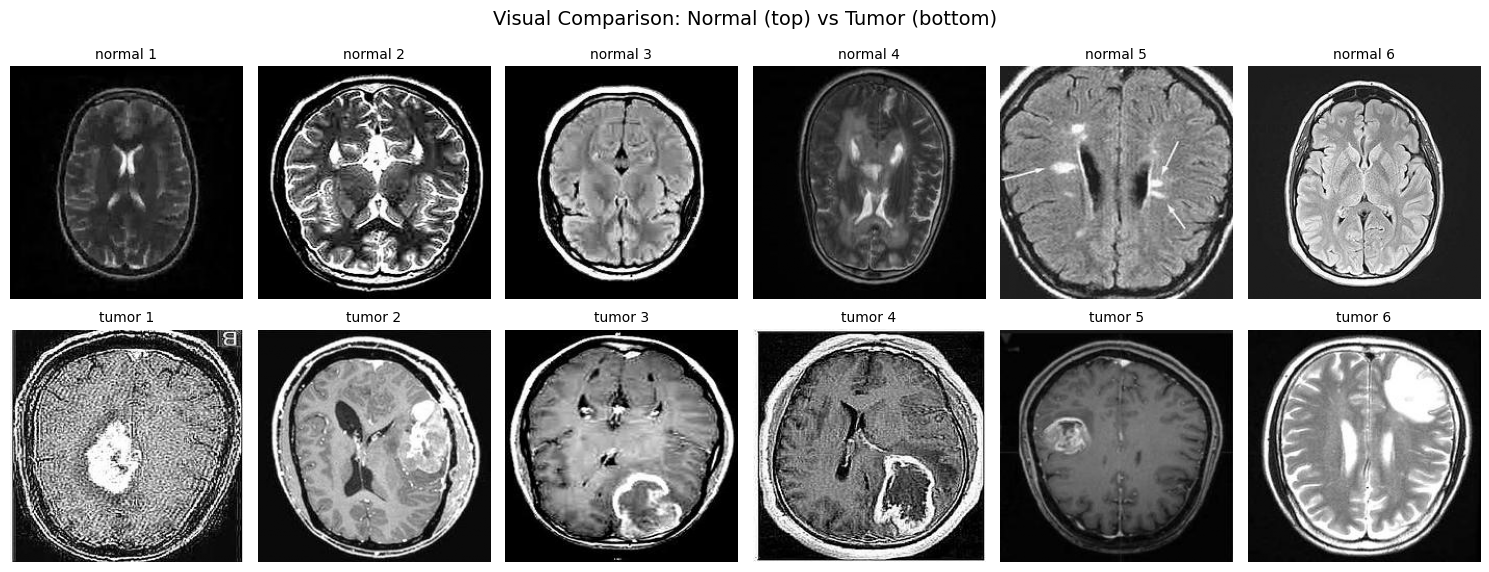

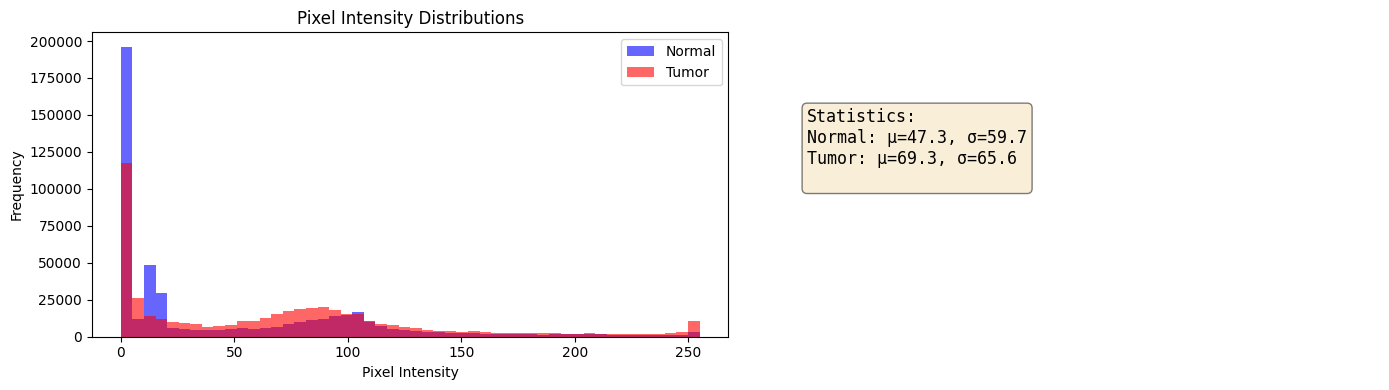

In [51]:
if __name__ == "__main__":
    print("\n" + "#"*70)
    print("# VALIDATING MODEL RESULTS")
    print("#"*70)

    # Run checks
    check_data_split()
    check_class_balance()
    check_visual_separation()
    check_pixel_distributions()

    print("\n" + "#"*70)
    print("# VALIDATION COMPLETE")
    print("#"*70)